# Demonstration of the iterative update in 2D

Exploration of an iterative solver scheme to solve the following three main blocs:
1. Source parameters
2. Attitude
3. Calibration parameters

The source parameters correspond to the _true_ values characterising each source (_What makes it a Global solution?_).

The attitude relates to the satellite telemetry: its pointing direction and orientation, as well as the focal distance.

The calibrations has to take care of everything else: distortions, translations, colour dependencies, etc.

This notebook demonstrates an optimization procedure for a simplistic 2D case where only positions are infered. In other words, stars do not move (relative to the Earth).

We use `jax` to make the best use of the _auto-differentiation_ technique.

In [442]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as units
import scipy.stats
jax.config.update('jax_enable_x64', True)
np.random.seed(42)

## Model

The observation model is defined here.

### Epoch Position

Each star has astrometric parameters $(\alpha_{0},\delta_{0})$, which correspond to the position in ICRS coordiantes at the catalog epoch. The catalog epoch is set $t=0$. The observed position of a star at the observation epoch, $\alpha_{i}(t),\delta_{i}(t)$, is given by the following expression.

$$
  \alpha_{i}(t) = \alpha_{0,i}
$$
$$
  \delta{i}(t) = \delta_{0,i}
$$

### Epoch Position with proper motions and parallax

Each star has astrometric parameters $(\alpha_{0},\delta_{0},\mu_{\alpha*},\mu_{\delta},\varpi)$, which correspond to the position in ICRS coordiantes at the catalog epoch, their proper motions and parallax. The catalog epoch is set $t=0$. The position of a star in ICRS at the observation epoch, $\alpha_{i}(t),\delta_{i}(t)$, is given by the following expression:

$$
  \alpha_{i}(t) = \frac{\alpha_{0,i} + \mu_{\alpha*}\tau + f_\alpha \varpi_0}{1 + \mu_{r0}\tau + f_r\varpi_0} \approx \alpha_{0,i} + \mu_{\alpha*}t + f_\alpha \varpi_0
$$
$$
  \delta{i}(t) = \frac{\delta_{0,i} + \mu_{\delta}\tau + f_\delta \varpi_0}{1 + \mu_{r0}\tau + f_r\varpi_0} \approx \delta_{0,i} + \mu_{\delta}t + f_\delta \varpi_0
$$

In [224]:
_astronomicalunit_to_meters = units.astronomical_unit.to(units.meter)
_radiants_to_mas = units.radian.to(units.mas)

In [297]:
def longitude(t):
  ''' Longitude of the Earth

  Arguments:
      t: epoch of the observation [years]

  Returns:
    The longitude of the Earth in radian.
  '''
  return 2 * jnp.pi * t

def get_p0(alpha0,delta0):
    """
    First vector of the reference triad. alpha0 and delta0 in radiants.
    """
    return jnp.array([-jnp.sin(alpha0),jnp.cos(alpha0),0])

def get_q0(alpha0,delta0):
    """
    Second vector of the reference triad. alpha0 and delta0 in radiants.
    """
    return jnp.array([-jnp.sin(delta0)*jnp.cos(alpha0),jnp.sin(delta0)*jnp.sin(alpha0),jnp.cos(delta0)])

def get_barycentric_position_satellite(time):
    return jnp.array([jnp.sin(longitude(time)),jnp.cos(longitude(time)),0])

def get_parallax_factor_vectorial(vec,bary):
    A = _astronomicalunit_to_meters
    return -jnp.dot(vec,bary)/A

def get_parallax_factor_alpha(time,alpha0,delta0):
    L = longitude(time)
    return jnp.sin(alpha0)*jnp.cos(L) - jnp.cos(alpha0)*jnp.sin(L)

def get_parallax_factor_delta(time,alpha0,delta0):
    L = longitude(time)
    return jnp.sin(delta0)*jnp.cos(alpha0)*jnp.cos(L) - jnp.sin(delta0)*jnp.sin(alpha0)*jnp.sin(L)

def get_alpha_t(time,alpha0,delta0,mu_alpha,parallax):
    """
    Predicted location of the right ascension of a source with linear motion on the tangential plane
    (Earth rotating on a circular orbit along the ICRS plane)
    - alpha0, delta0: in radians
    - mu_alpha: in mas/yr
    - parallax: in mas
    - time: in yr
    """
    parallax_factor = get_parallax_factor_alpha(time,alpha0,delta0)
    return alpha0*_radiants_to_mas + time*mu_alpha + parallax_factor*parallax

def get_delta_t(time,alpha0,delta0,mu_delta,parallax):
    """
    Predicted location of the declination of a source with linear motion on the tangential plane
    (Earth rotating on a circular orbit along the ICRS plane)
    - alpha0, delta0: in radians
    - mu_delta: in mas/yr
    - parallax: in mas
    - time: in yr
    """
    parallax_factor = get_parallax_factor_delta(time,alpha0,delta0)
    return delta0*_radiants_to_mas + time*mu_delta + parallax_factor*parallax

def celestial_model(angle,pm,parallax,parallax_factor,t):
    """
    Celestial model describing the motion on the Celestial sphere of a star.
    1D
    """
    return angle + pm * t + parallax * parallax_factor

In [247]:
t = np.linspace(0,3,1000)
a0 = 0
d0 = np.pi/4
mua0 = 10
mud0 = -5
plx = 5

a = get_alpha_t(t,a0,d0,mua0,plx)
d = get_delta_t(t,a0,d0,mud0,plx)

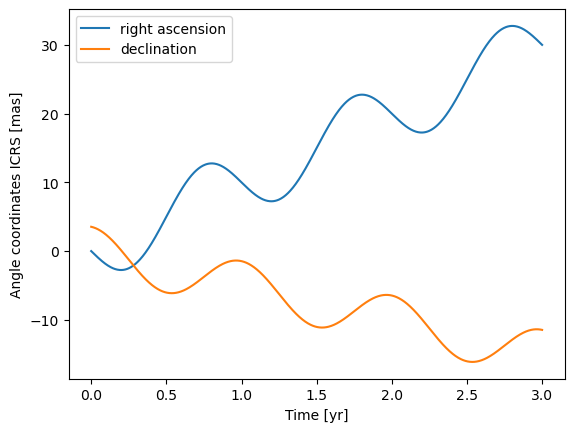

In [252]:
plt.plot(t,a-a0*_radiants_to_mas,label="right ascension")
plt.plot(t,d-d0*_radiants_to_mas,label="declination")
plt.legend()
plt.xlabel("Time [yr]")
plt.ylabel("Angle coordinates ICRS [mas]");

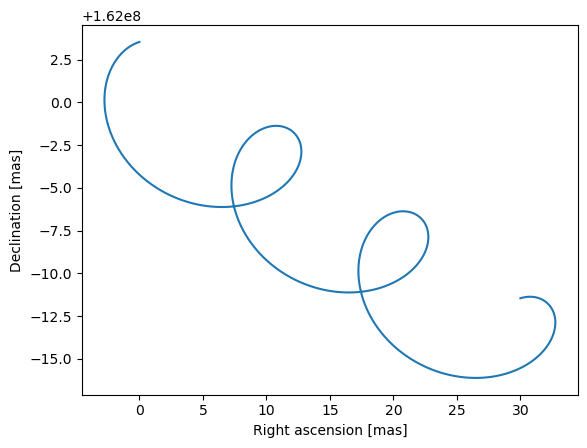

In [253]:
plt.plot(a,d)
plt.xlabel("Right ascension [mas]")
plt.ylabel("Declination [mas]");

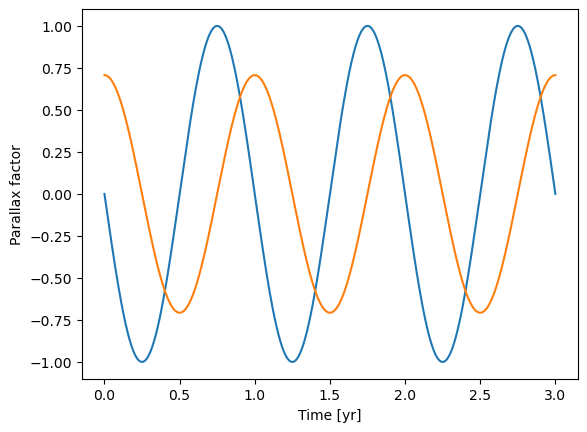

In [254]:
plt.plot(t,get_parallax_factor_alpha(t,a0,d0),label="right ascension")
plt.plot(t,get_parallax_factor_delta(t,a0,d0),label="declination")
plt.xlabel("Time [yr]");
plt.ylabel("Parallax factor");

In [3]:
def epoch_position(s, t):
    ''' Celestial position of a source
    
    Arguments:
      s: source parameters
        s[0]: right ascention
        s[1]: declination
    
    Returns:
    The celestial position of the source at the observation epoch.
    '''
    return s[0], s[1]

In [266]:
def position_ideal_plane_eta(s, e, t):
    ''' Position eta on the ideal focal plane
    
    Arguments:
    s: source parameters
    e: exposure parameters
        e[0]: telescope pointing in right ascension [radiants]
        e[1]: telescope pointing in declination [radiants]
    
    Returns:
    The position on the ideal focal plane at the observation epoch. FoV reference system.
    '''
    alpha = get_alpha_t(t,s[0],s[1],s[2],s[-1])/_radiants_to_mas
    eta = alpha - e[0]
    return eta

def position_ideal_plane_zeta(s, e, t):
    ''' Position zeta on the ideal focal plane
    
    Arguments:
    s: source parameters
    e: exposure parameters
        e[0]: telescope pointing in right ascension [radiants]
        e[1]: telescope pointing in declination [radiants]
    
    Returns:
    The position on the ideal focal plane at the observation epoch. FoV reference system.
    '''
    delta = get_delta_t(t,s[0],s[1],s[3],s[-1])/_radiants_to_mas
    zeta = delta - e[1]
    return zeta

In [267]:
def position_focal_plane(s, e, t):
    ''' Position on the actual focal plane
    
    Arguments:
    s: source parameters
    e: exposure parameters
    
    Returns:
    Ideally, the position on the focal plane (Detector reference system) with distortion. 
    For now, it changes nothing. There is no projection onto a flat plane either.
    '''
    eta,zeta = position_ideal_plane(s, e, t)
    
    return eta,zeta

def position_focal_plane_eta(s, e, t):
    ''' Position on the actual focal plane
    
    Arguments:
    s: source parameters
    e: exposure parameters
    
    Returns:
    Ideally, the position on the focal plane (Detector reference system) with distortion. 
    For now, it changes nothing. There is no projection onto a flat plane either.
    '''
    eta = position_ideal_plane_eta(s, e, t)
    
    return eta

def position_focal_plane_zeta(s, e, t):
    ''' Position on the actual focal plane
    
    Arguments:
    s: source parameters
    e: exposure parameters
    
    Returns:
    Ideally, the position on the focal plane (Detector reference system) with distortion. 
    For now, it changes nothing. There is no projection onto a flat plane either.
    '''
    zeta = position_ideal_plane_zeta(s, e, t)
    
    return zeta


eta = jax.jit(lambda s,e,t: position_focal_plane_eta(s,e,t))
zeta = jax.jit(lambda s,e,t: position_focal_plane_zeta(s,e,t))

## Generate simulation (NO SCALING NO DEFORMATIONS)

We set up the simulation. We prepare 200 artificial sources. The astrometric parameters are randomly sampled. The observations are scheduled from $t=-10$ to $10$ with equal intervals. The number of observations is 501. The telescope pointing directions are randomly sampled. 

`src` and `exp` contain the ground truth of the parameters. `src` contains the source astrometric parameters with `source_id`. `exp` contains the exposure parameters with `exposure_id`.

In [526]:
pkey = jax.random.PRNGKey(42)

source_id = jnp.arange(200)
alpha0 = np.random.uniform(-1.0, 1.0, size=source_id.shape)
delta0 = np.random.uniform(-1.0, 1.0, size=source_id.shape)
pmalpha0 = np.random.normal(0,5, size=source_id.shape)
pmdelta0 = np.random.normal(0,5, size=source_id.shape)
parallax0 = np.random.normal(5,1, size=source_id.shape)#np.random.exponential(5, size=source_id.shape)#np.ones_like(source_id)*5

exposure_id = jnp.arange(501)
ep = jnp.linspace(0,3, exposure_id.size)
pt_ra = np.random.uniform(-2.0, 2.0, size=exposure_id.shape)/10000
pt_dec = np.random.uniform(-2.0, 2.0, size=exposure_id.shape)/10000

src = jnp.stack([source_id, alpha0, delta0,pmalpha0,pmdelta0,parallax0]).T
exp = jnp.stack([exposure_id, ep, pt_ra,pt_dec]).T

In [529]:
scipy.stats.describe(parallax0)

DescribeResult(nobs=200, minmax=(1.3116347085715558, 7.721912147906493), mean=4.9125677036998265, variance=1.157393459477073, skewness=-0.24115023827424562, kurtosis=0.22549919913693106)

The initial estimates of the parameters are prepared. We assume that the source and exposure parameters can be estimated with uncertainties of 5%. We set the initial estimates of the calibration paramters to zeros.

In [530]:
shat = jnp.hstack([src[:, 0:1], src[:, 1:] * np.random.normal(1.0, 0.1, size=src[:, 1:].shape)])
ehat = jnp.hstack([exp[:, 0:2], exp[:, 2:] * np.random.normal(1.0, 0.1, size=exp[:, 2:].shape)])

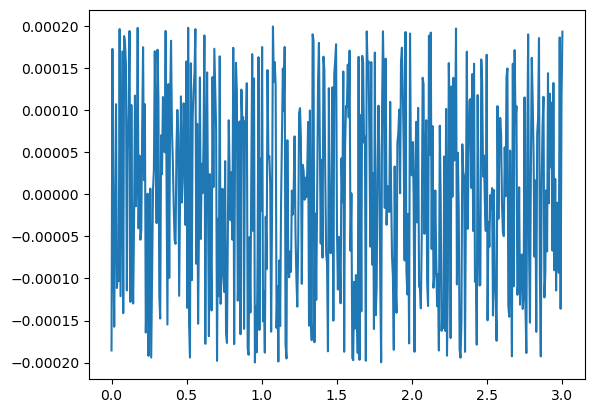

In [531]:
plt.plot(ep,pt_ra)

## Generate measurements

Predictions of the astrometric model are generated using the function `zeta`. The predictions can be affected by noise if desired, for instance, to generate mock observations. Here, we assume that the measurement error is given by a Gaussian distribution with the standard deviation of $\sigma_\text{obs}$.

$$
  \tilde\zeta_{i}(t) = \mathcal{N}(\zeta_{i}(t), \sigma_\text{obs})
$$

In [532]:
_iterate_src_eta = jax.vmap(eta, (0, None, None), 0)
_iterate_exp_eta = jax.vmap(eta, (None, 0, 0), 0)
_iterate_full_eta = jax.vmap(_iterate_src_eta, (None, 0, 0), 0)
exposure_eta = lambda s, e, t: _iterate_full_eta(s, e, t).ravel()

_iterate_src_zeta = jax.vmap(zeta, (0, None, None), 0)
_iterate_exp_zeta = jax.vmap(zeta, (None, 0, 0), 0)
_iterate_full_zeta = jax.vmap(_iterate_src_zeta, (None, 0, 0), 0)
exposure_zeta = lambda s, e, t: _iterate_full_zeta(s, e, t).ravel()


def estimate(src, exp, noise=0.00):
    ''' Generate the focal plane position from the parameters
    
    Arguments:
      src: source parameters
      exp: exposure parameters
      cal: calibration parameters
    
    Returns:
    The estimated measurements for the given paramters.
    The measurements are disturbed if noise is not zero.
    '''
    eta_obs = exposure_eta(src[:, 1:], exp[:, 2:], exp[:, 1])
    zeta_obs = exposure_zeta(src[:, 1:], exp[:, 2:], exp[:, 1])
    obs = jnp.hstack([eta_obs,zeta_obs])
    if noise > 0:
        obs = np.random.normal(obs, noise)
    sid = jnp.tile(src[:, 0], 2*exp.shape[0])
    eid = jnp.repeat(exp[:, 0], src.shape[0])
    eid = jnp.hstack([eid,eid])
    axis = jnp.hstack([jnp.zeros(exp.shape[0]*src.shape[0]),jnp.ones(exp.shape[0]*src.shape[0])])
    return jnp.stack([sid, eid, axis, obs]).T

sig_obs = 0
obs = estimate(src, exp, noise=sig_obs)

In [533]:
obs.shape

(200400, 4)

In [534]:
src[0]

Array([ 0.        ,  0.99202557, -0.83225252,  3.16612655,  2.28124744,
        4.33266662], dtype=float64)

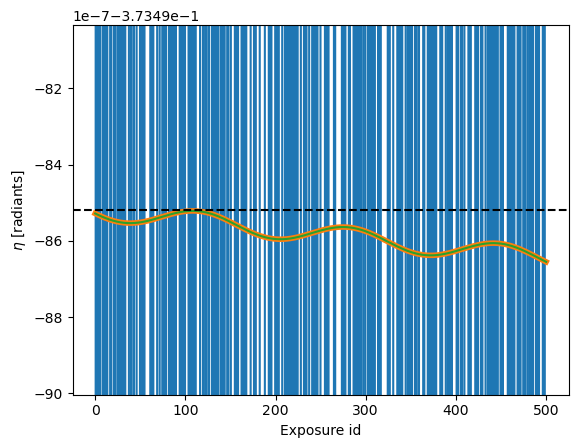

In [535]:
k = 100
plt.plot(obs[(obs[:,0]==k)&(obs[:,2]==0)][:,1],obs[(obs[:,0]==k)&(obs[:,2]==0)][:,-1])

plt.plot(obs[(obs[:,0]==k)&(obs[:,2]==0)][:,1],
         obs[(obs[:,0]==k)&(obs[:,2]==0)][:,-1] + ehat2[:,2],lw=4,color="tab:grey")

plt.plot(obs[(obs[:,0]==k)&(obs[:,2]==0)][:,1],
         obs[(obs[:,0]==k)&(obs[:,2]==0)][:,-1] + pt_ra,lw=4,color="tab:orange")


plt.plot(obs[(obs[:,0]==k)&(obs[:,2]==0)][:,1],
         get_alpha_t(ep,alpha0[k],delta0[k],pmalpha0[k],parallax0[k])/_radiants_to_mas,color="tab:green")
plt.axhline(alpha0[k],ls="--",color="k")
plt.ylim(alpha0[k]-100/_radiants_to_mas,alpha0[k]+100/_radiants_to_mas)
plt.xlabel("Exposure id")
plt.ylabel(r"$\eta$ [radiants]");

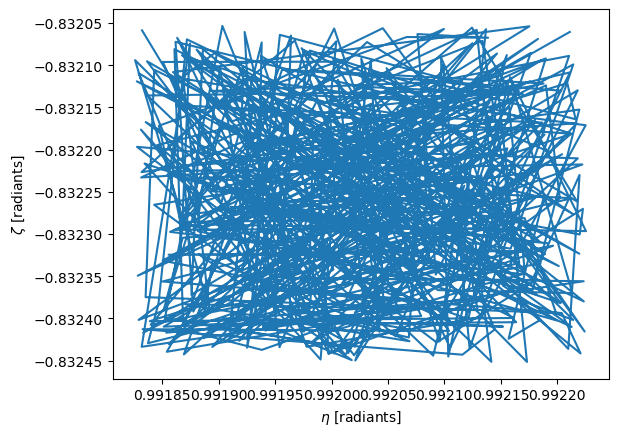

In [536]:
plt.plot(obs[(obs[:,0]==0)&(obs[:,2]==0)][:,-1],obs[(obs[:,0]==0)&(obs[:,2]==1)][:,-1])
plt.ylabel(r"$\zeta$ [radiants]")
plt.xlabel(r"$\eta$ [radiants]");

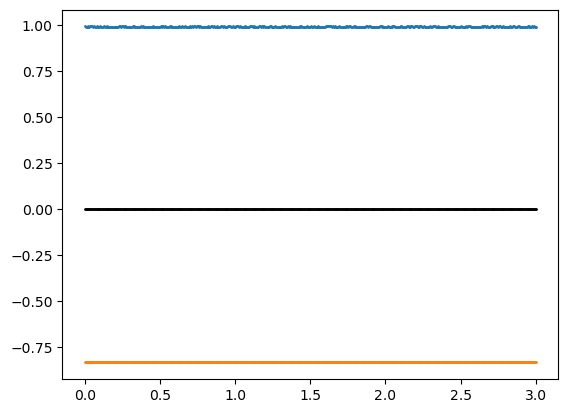

In [537]:
aux = obs[obs[:,0]==0]
plt.scatter(exp[:,1],aux[:exp.shape[0],3],s=1)
plt.scatter(exp[:,1],aux[exp.shape[0]:,3],s=1)
plt.scatter(exp[:,1],exp[:,2],s=1,c="k")

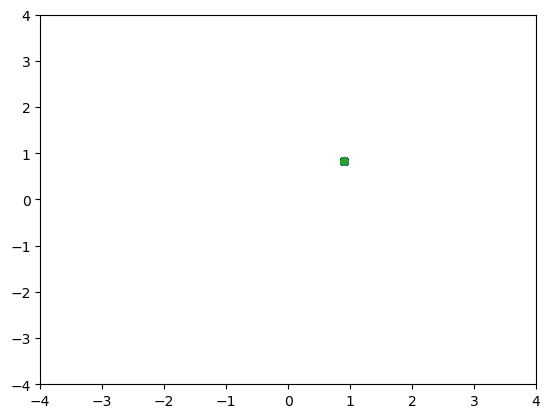

In [538]:
k = 50
aux = obs[obs[:,0]==k]
plt.scatter(aux[:exp.shape[0],3],aux[exp.shape[0]:,3],s=30)
plt.scatter(src[k,1],src[k,2],marker="*",color="k")
plt.scatter(src[k,1]-exp[:,2],src[k,2]-exp[:,3],color="tab:green",s=20)

plt.xlim(-4,4)
plt.ylim(-4,4);

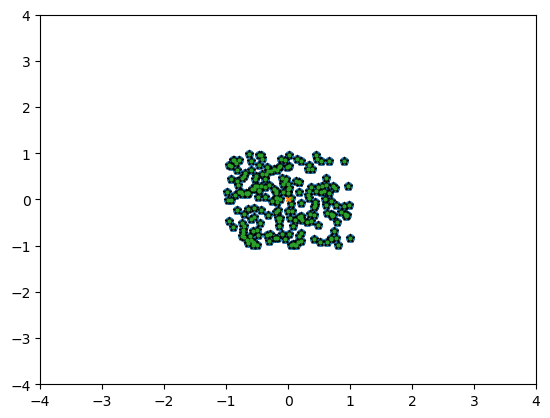

In [539]:
k = 200
aux = obs[obs[:,1]==k]
plt.scatter(aux[:src.shape[0],3],aux[src.shape[0]:,3],s=30)
plt.scatter(src[:,1],src[:,2],marker="*",color="k")
plt.scatter(src[:,1]-exp[k,2],src[:,2]-exp[k,3],color="tab:green",s=4)
plt.scatter(-exp[k,2],-exp[k,3],c="tab:orange",s=10,marker="x")

plt.xlim(-4,4)
plt.ylim(-4,4);

We define a function to visualize the residuals of the parameters from the ground truth.

In [16]:
def visualize(sx, ex, cx):
  def residual(z):
    return jnp.sqrt(jnp.mean((obs[:, 2] - z[:, 2])**2))

  def limit_range(p0, p1, index):
    m = min([min(p0[:, index]), min(p1[:, index])])
    M = max([max(p0[:, index]), max(p1[:, index])])
    return m, M

  fig, axes = plt.subplots(2, 3, figsize=(12, 8))

  ax = axes[0, 0]
  r = limit_range(src, sx, 1)
  ax.plot(r, r, color='C3', lw=0.5)
  ax.scatter(src[:, 1], sx[:, 1], marker='.', label='position')
  ax.set_aspect(1.0, adjustable='datalim')
  ax.legend()

  ax = axes[0, 1]
  r = limit_range(src, sx, 2)
  ax.plot(r, r, color='C3', lw=0.5)
  ax.scatter(src[:, 2], sx[:, 2], marker='.', label='motion')
  ax.set_aspect(1.0, adjustable='datalim')
  ax.legend()

  ax = axes[0, 2]
  r = limit_range(src, sx, 3)
  ax.plot(r, r, color='C3', lw=0.5)
  ax.scatter(src[:, 3], sx[:, 3], marker='.', label='parallax')
  ax.set_aspect(1.0, adjustable='datalim')
  ax.legend()

  ax = axes[1, 0]
  r = limit_range(exp, ex, 2)
  ax.plot(r, r, color='C3', lw=0.5)
  ax.scatter(exp[:, 2], ex[:, 2], marker='.', label='pointing')
  ax.set_aspect(1.0, adjustable='datalim')
  ax.legend()

  ax = axes[1, 1]
  r = limit_range(exp, ex, 3)
  ax.plot(r, r, color='C3', lw=0.5)
  ax.scatter(exp[:, 3], ex[:, 3], marker='.', label='scale')
  ax.set_aspect(1.0, adjustable='datalim')
  ax.legend()

  ax = axes[1, 2]
  r = min(cal), max(cal)
  ax.plot(r, r, color='C3', lw=0.5)
  for n in range(cal.size):
    ax.scatter(cal[n], cx[n], marker='.', label=f'calibration-{n}')
  ax.set_aspect(1.0, adjustable='datalim')
  ax.legend()

  fig.supxlabel('Ground Truth parameters', fontsize=16)
  fig.supylabel('Estimated parameters', fontsize=16)
  fig.tight_layout()
  plt.show()

  fig, ax = plt.subplots(figsize=(12, 4))

  z = estimate(sx, ex, cx)
  res = residual(z)
  ax.plot(
    obs[:, 1], jnp.zeros_like(z[:,2]),
    color='C2')
  ax.scatter(
    obs[:, 1], z[:, 2] - obs[:, 2],
    s=1, marker='.', color='C1',
    label=f'residual: {res:.3f}')
  ax.set_xlabel('Exposure ID', fontsize=16)
  ax.set_ylabel('Residual', fontsize=16)
  ax.set_ylim([-0.15, 0.15])
  ax.legend(loc='upper right', fontsize=14, frameon=False)

  fig.tight_layout()
  plt.show()

## Calculate gradients

Gradient functions are obtained via `jax.grad`. Three functions are defined:

- `dzds`: Gradients in terms of the source parameters.
- `dzde`: Gradients in terms of the exposure parameters.
- `dzdc`: Gradients in terms of the calibration parameters.

In [405]:
dzds = jax.vmap(jax.grad(zeta, argnums=(0)), (None, 0, 0))
dzde = jax.vmap(jax.grad(zeta, argnums=(1)), (0, None, None))

deds = jax.vmap(jax.grad(eta, argnums=(0)), (None, 0, 0))
dede = jax.vmap(jax.grad(eta, argnums=(1)), (0, None, None))

In [406]:
aux = jax.grad(zeta, argnums=(0))

## Calculate update

The updates of the parameters are obtained via the gradients. We define three functions:

- `update_source` returns the updated source parameters.
- `update_exposure` returns the updated exposure parameters.
- `update_calibration` returns the updated calibration parameters.

In [282]:
def update_source_inner(src, exp):
    c_eta = _iterate_exp_eta(src[1:],exp[:,2:],exp[:,1])
    o_eta = obs[(obs[:, 0] == src[0])&(obs[:,2]==0)][:, 3]
    
    c_zeta = _iterate_exp_zeta(src[1:],exp[:,2:],exp[:,1])
    o_zeta = obs[(obs[:, 0] == src[0])&(obs[:,2]==1)][:, 3]

    o = jnp.hstack([o_eta,o_zeta])
    c = jnp.hstack([c_eta,c_zeta])
    
    Ds = np.vstack([deds(src[1:], exp[:, 2:], exp[:, 1]),
                    dzds(src[1:], exp[:, 2:], exp[:, 1])])

    
    
    N = Ds.T @ Ds
    b = Ds.T @ (o - c)
    
    cfac = jax.scipy.linalg.cho_factor(N)
    delta = jax.scipy.linalg.cho_solve(cfac, b)
    return src[1:] + delta

def update_source(src, exp):
  ''' Updates of the source parameters

  Arguments:
      src: source parameters
      exp: exposure parameters
      cal: calibration parameters

  Returns:
    The updated source paraemters.
  '''
  return jnp.vstack([update_source_inner(_, exp) for _ in src])

In [407]:
update_source_inner(shat[0],exp)

Array([-0.14924724, -0.25788165,  5.0560603 , 10.2423534 ,  4.9979492 ],      dtype=float64)

In [408]:
src[0]

Array([ 0.        , -0.14924724, -0.25788165,  5.05555988, 10.24261587,
        5.        ], dtype=float64)

In [285]:
def update_exposure_inner(src, exp):
    c_eta = _iterate_src_eta(src[:,1:], exp[2:],exp[1])
    o_eta = obs[(obs[:, 1] == exp[0])&(obs[:,2]==0)][:, 3]
    
    c_zeta = _iterate_src_zeta(src[:,1:], exp[2:],exp[1])
    o_zeta = obs[(obs[:, 1] == exp[0])&(obs[:,2]==1)][:, 3]

    o = jnp.hstack([o_eta,o_zeta])
    c = jnp.hstack([c_eta,c_zeta])
    
    De = np.vstack([dede(src[:,1:], exp[2:], exp[1]),
                    dzde(src[:,1:], exp[2:], exp[1])])

    
    
    N = De.T @ De
    b = De.T @ (o - c)
    
    cfac = jax.scipy.linalg.cho_factor(N)
    delta = jax.scipy.linalg.cho_solve(cfac, b)
    return exp[2:] + delta

def update_exposure(src, exp):
  ''' Updates of the exposure parameters

  Arguments:
      src: source parameters
      exp: exposure parameters
      cal: calibration parameters

  Returns:
    The updated exposure paraemters.
  '''
  return jnp.vstack([update_exposure_inner(src, _) for _ in exp])

In [409]:
update_exposure_inner(src,exp[0])

Array([-0.00012536,  0.00017087], dtype=float64)

In [410]:
exp[0]

Array([ 0.        ,  0.        , -0.00012536,  0.00017087], dtype=float64)

## Update parameters

We demonstrate the parameter optimization with the AGIS-like approach. First, we visualize the residuals calculated for the initial estimates. The horizontal axes show the ground truth values, and the vertical axes shows the estimated parameters. The bottom panel shows the residuals against the exposure ID. The root-mean-squared residual is denoted in the legend. Since the measurement error is $\sigma_\text{obs} = 0.015$, the RMS residual will be 0.015 when the parameters are successfully converged.

### Updating attitude first and then source

In [540]:
ehat1 = jnp.column_stack((ehat[:,:2],update_exposure(shat,ehat)))
shat1 = jnp.column_stack((shat[:,0],update_source(shat,ehat1)))

ehat2 = jnp.column_stack((ehat[:,:2],update_exposure(shat1,ehat1)))
shat2 = jnp.column_stack((shat[:,0],update_source(shat1,ehat2)))

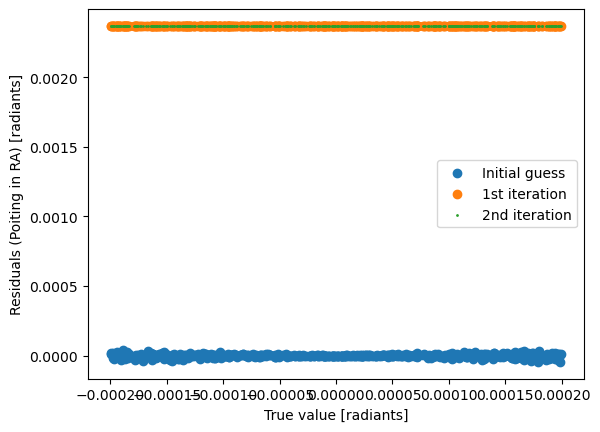

In [541]:
j = 0
plt.scatter(exp[:,2+j],ehat[:,2+j]-exp[:,2+j],label="Initial guess")
plt.scatter(exp[:,2+j],ehat1[:,2+j]-exp[:,2+j],label="1st iteration")
plt.scatter(exp[:,2+j],ehat2[:,2+j]-exp[:,2+j],label="2nd iteration",s=1)
if j==0:
    plt.ylabel("Residuals (Poiting in RA) [radiants]")
elif j==1:
    plt.ylabel("Residuals (Poiting in DEC) [radiants]")
plt.xlabel("True value [radiants]")
plt.legend();

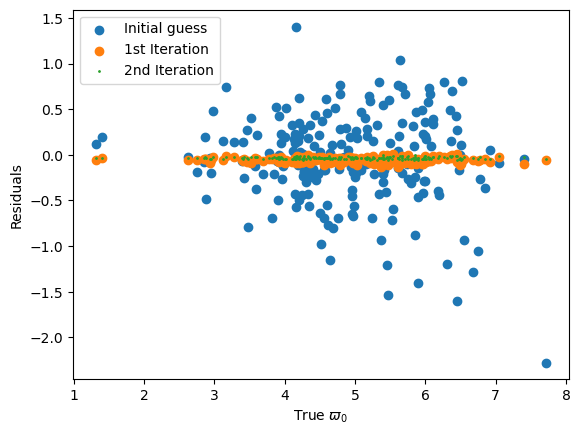

In [542]:
j = 4
plt.scatter(src[:,1+j],shat[:,1+j]-src[:,1+j],label="Initial guess")
plt.scatter(src[:,1+j],shat1[:,1+j]-src[:,1+j],label="1st Iteration")
plt.scatter(src[:,1+j],shat2[:,1+j]-src[:,1+j],label="2nd Iteration",s=1)
plt.legend()

plt.xlabel("{}".format([r"True $\alpha_0$",r"True $\delta_0$",r"True $\mu_{\alpha_0}$",
                        r"True $\mu_{\delta_0}$",r"True $\varpi_0$"][j]));
plt.ylabel("Residuals");

In [543]:
scipy.stats.describe(ehat1[:,2]-exp[:,2])

DescribeResult(nobs=501, minmax=(0.00236840440446156, 0.0023684053916301706), mean=0.002368404912050714, variance=7.910984757661783e-20, skewness=-0.07930561155129699, kurtosis=-1.1699955943262677)

In [544]:
scipy.stats.describe(shat1[:,1]-src[:,1])

DescribeResult(nobs=200, minmax=(0.0023684045806749987, 0.0023684049933135887), mean=0.0023684047560502373, variance=2.0674114077244615e-21, skewness=0.42002184706806667, kurtosis=5.937466224314992)

In [545]:
scipy.stats.describe(ehat1[:,3]-exp[:,3])

DescribeResult(nobs=501, minmax=(-0.008290807646567408, -0.008290806859105755), mean=-0.008290807216424301, variance=4.835968038552678e-20, skewness=-0.09222334957074113, kurtosis=-0.8683202964999124)

In [546]:
scipy.stats.describe(shat1[:,2]-src[:,2])

DescribeResult(nobs=200, minmax=(-0.008290807004466605, -0.008290806727904165), mean=-0.008290806855171456, variance=1.716602839175673e-21, skewness=-0.25160227184942907, kurtosis=1.0969830143654828)

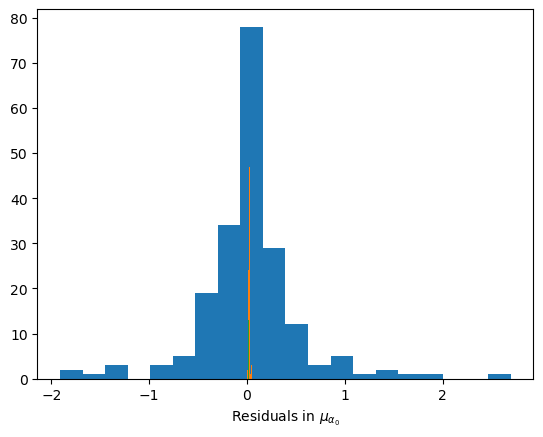

In [547]:
j = 2
plt.hist(shat[:,1+j]-src[:,1+j],bins=20,label="Initial guess")
plt.hist(shat1[:,1+j]-src[:,1+j],bins=20,label="1st Iteration")
plt.hist(shat2[:,1+j]-src[:,1+j],bins=20,label="2nd Iteration");

plt.xlabel("Residuals in {}".format([r"$\alpha_0$",r"$\delta_0$",r"$\mu_{\alpha_0}$",
                        r"$\mu_{\delta_0}$",r"$\varpi_0$"][j]));

In [548]:
scipy.stats.describe(ehat2[:,2]-pt_ra)

DescribeResult(nobs=501, minmax=(0.002368404568876542, 0.0023684052393774194), mean=0.0023684049120688373, variance=3.356244603947356e-20, skewness=-0.07655600894184868, kurtosis=-0.9874581940807277)

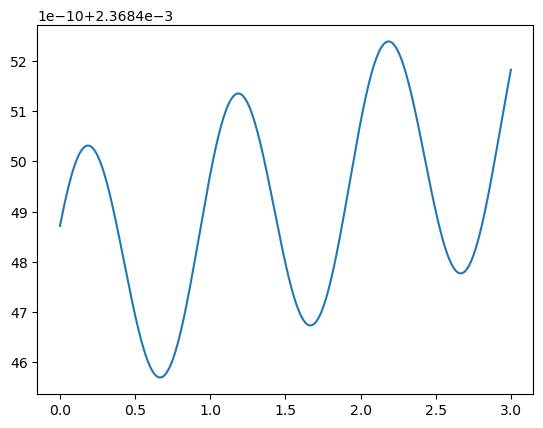

In [549]:
plt.plot(ep,ehat2[:,2]-pt_ra)

(0.9943934868628843, 0.9943944564902465)

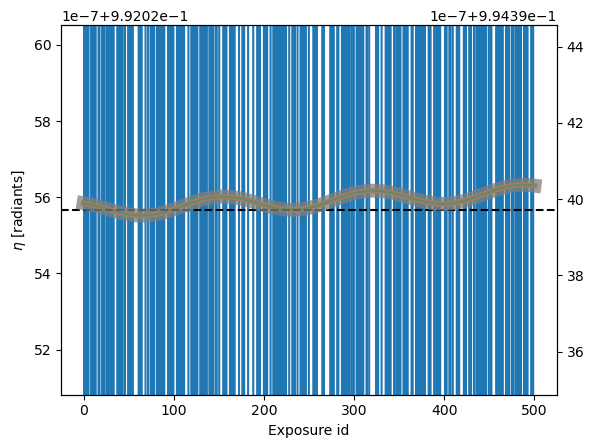

In [550]:
k = 0
plt.plot(obs[(obs[:,0]==k)&(obs[:,2]==0)][:,1],obs[(obs[:,0]==k)&(obs[:,2]==0)][:,-1])

plt.plot(obs[(obs[:,0]==k)&(obs[:,2]==0)][:,1],
         obs[(obs[:,0]==k)&(obs[:,2]==0)][:,-1] + pt_ra,lw=4,color="tab:orange")


plt.plot(obs[(obs[:,0]==k)&(obs[:,2]==0)][:,1],
         get_alpha_t(ep,alpha0[k],delta0[k],pmalpha0[k],parallax0[k])/_radiants_to_mas,color="tab:green")
plt.axhline(alpha0[k],ls="--",color="k")
plt.ylim(alpha0[k]-100/_radiants_to_mas,alpha0[k]+100/_radiants_to_mas)

plt.xlabel("Exposure id")
plt.ylabel(r"$\eta$ [radiants]");

ax = plt.gca().twinx()

offset = np.mean(pt_ra - ehat2[:,2])
ax.plot(obs[(obs[:,0]==k)&(obs[:,2]==0)][:,1],
         obs[(obs[:,0]==k)&(obs[:,2]==0)][:,-1] + ehat2[:,2],lw=10,color="tab:grey",alpha=0.75)
ax.set_ylim(alpha0[k]-100/_radiants_to_mas-offset,alpha0[k]+100/_radiants_to_mas-offset)

### Updating source first and then attitue

In [465]:
shat1 = jnp.column_stack((shat[:,0],update_source(shat,ehat)))
ehat1 = jnp.column_stack((ehat[:,:2],update_exposure(shat1,ehat)))

shat2 = jnp.column_stack((shat[:,0],update_source(shat1,ehat1)))
ehat2 = jnp.column_stack((ehat[:,:2],update_exposure(shat2,ehat)))

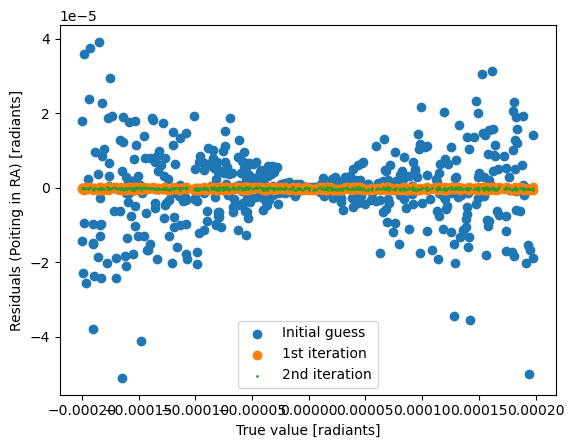

In [466]:
j = 0
plt.scatter(exp[:,2+j],ehat[:,2+j]-exp[:,2+j],label="Initial guess")
plt.scatter(exp[:,2+j],ehat1[:,2+j]-exp[:,2+j],label="1st iteration")
plt.scatter(exp[:,2+j],ehat2[:,2+j]-exp[:,2+j],label="2nd iteration",s=1)
if j==0:
    plt.ylabel("Residuals (Poiting in RA) [radiants]")
elif j==1:
    plt.ylabel("Residuals (Poiting in DEC) [radiants]")
plt.xlabel("True value [radiants]")
plt.legend();

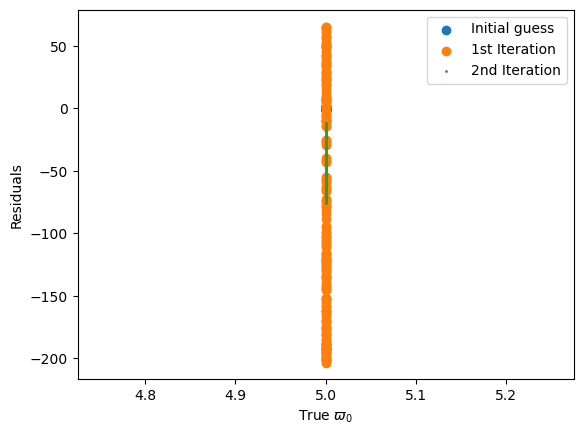

In [467]:
j = 4
plt.scatter(src[:,1+j],shat[:,1+j]-src[:,1+j],label="Initial guess")
plt.scatter(src[:,1+j],shat1[:,1+j]-src[:,1+j],label="1st Iteration")
plt.scatter(src[:,1+j],shat2[:,1+j]-src[:,1+j],label="2nd Iteration",s=1)
plt.legend()

plt.xlabel("{}".format([r"True $\alpha_0$",r"True $\delta_0$",r"True $\mu_{\alpha_0}$",
                        r"True $\mu_{\delta_0}$",r"True $\varpi_0$"][j]));
plt.ylabel("Residuals");

In [468]:
scipy.stats.describe(ehat1[:,2]-exp[:,2])

DescribeResult(nobs=501, minmax=(-6.962297231706548e-07, 2.3278596512531973e-07), mean=-2.3149175398700686e-07, variance=7.573155653727277e-14, skewness=-0.0022333290905034078, kurtosis=-1.3052487360693639)

In [469]:
scipy.stats.describe(shat1[:,1]-src[:,1])

DescribeResult(nobs=200, minmax=(-2.8376969397891916e-07, 1.261191212298396e-07), mean=-8.065864909781299e-08, variance=1.5624060740088458e-14, skewness=-0.09483878699095334, kurtosis=-1.2743862582248815)

In [470]:
scipy.stats.describe(ehat1[:,3]-exp[:,3])

DescribeResult(nobs=501, minmax=(-7.978901635048439e-07, -3.487964754120222e-07), mean=-5.785928110259823e-07, variance=1.9720477492102492e-14, skewness=0.00254443235064514, kurtosis=-1.4415867799266966)

In [471]:
scipy.stats.describe(shat1[:,2]-src[:,2])

DescribeResult(nobs=200, minmax=(-7.384324145487398e-07, -4.97655169517941e-07), mean=-6.128685942738149e-07, variance=2.0995568990290585e-15, skewness=-0.11516548408260019, kurtosis=1.0378957363094425)

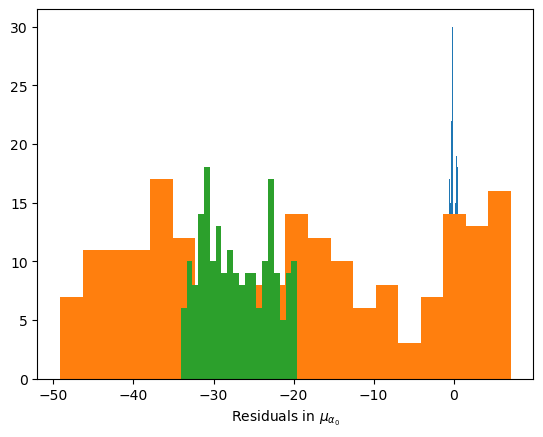

In [472]:
j = 2
plt.hist(shat[:,1+j]-src[:,1+j],bins=20,label="Initial guess")
plt.hist(shat1[:,1+j]-src[:,1+j],bins=20,label="1st Iteration")
plt.hist(shat2[:,1+j]-src[:,1+j],bins=20,label="2nd Iteration");

plt.xlabel("Residuals in {}".format([r"$\alpha_0$",r"$\delta_0$",r"$\mu_{\alpha_0}$",
                        r"$\mu_{\delta_0}$",r"$\varpi_0$"][j]));

In [473]:
scipy.stats.describe(ehat2[:,2]-pt_ra)

DescribeResult(nobs=501, minmax=(-5.907953698366085e-07, 1.266405475167532e-07), mean=-2.3149175380215356e-07, variance=3.981565294880455e-14, skewness=-0.005906296734371302, kurtosis=-0.9492464915328211)

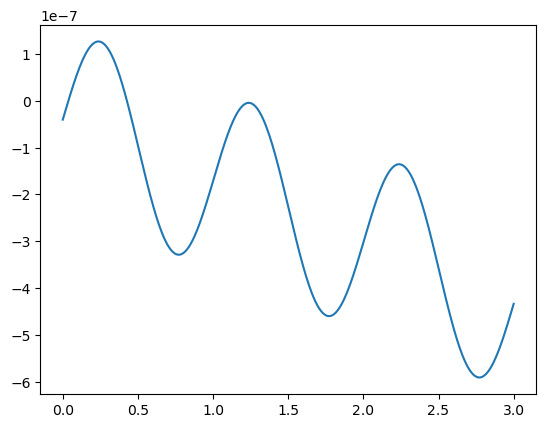

In [474]:
plt.plot(ep,ehat2[:,2]-pt_ra)

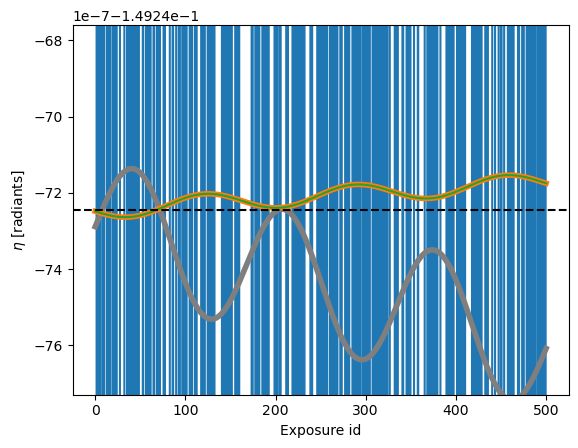

In [475]:
k = 0
plt.plot(obs[(obs[:,0]==k)&(obs[:,2]==0)][:,1],obs[(obs[:,0]==k)&(obs[:,2]==0)][:,-1])

plt.plot(obs[(obs[:,0]==k)&(obs[:,2]==0)][:,1],
         obs[(obs[:,0]==k)&(obs[:,2]==0)][:,-1] + ehat2[:,2],lw=4,color="tab:grey")

plt.plot(obs[(obs[:,0]==k)&(obs[:,2]==0)][:,1],
         obs[(obs[:,0]==k)&(obs[:,2]==0)][:,-1] + pt_ra,lw=4,color="tab:orange")


plt.plot(obs[(obs[:,0]==k)&(obs[:,2]==0)][:,1],
         get_alpha_t(ep,alpha0[k],delta0[k],pmalpha0[k],parallax0[k])/_radiants_to_mas,color="tab:green")
plt.axhline(alpha0[k],ls="--",color="k")
plt.ylim(alpha0[k]-100/_radiants_to_mas,alpha0[k]+100/_radiants_to_mas)
plt.xlabel("Exposure id")
plt.ylabel(r"$\eta$ [radiants]");

NameError: name 'cal' is not defined

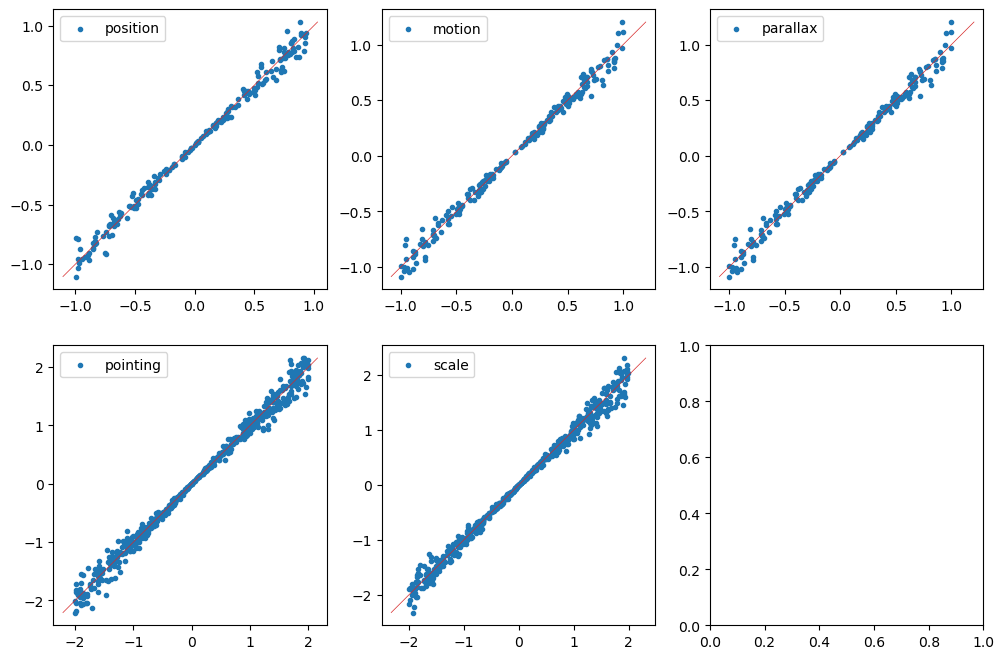

In [64]:
sx = shat
ex = ehat
visualize(sx, ex, None)

We measure typical errors of the source parameters by the sample standard deviations of the residuals against the ground truth. The numbers in the parentheses are relative error to the scaled measurement error ($\sigma_\text{obs}/N_\text{obs}$).

In [16]:
rms = np.std(sx[:, 1:] - src[:, 1:], axis=0)
sigN = sig_obs / np.sqrt(exp.shape[0])

print(f'A typical error in positions     : {rms[0]:.5f} ({rms[0] / sigN:.4f})')
print(f'A typical error in proper motions: {rms[1]:.5f} ({rms[1] / sigN:.4f})')
print(f'A typical error in parallaxes    : {rms[2]:.5f} ({rms[2] / sigN:.4f})')

A typical error in positions     : 0.05905 (88.1144)
A typical error in proper motions: 0.00121 (1.7988)
A typical error in parallaxes    : 0.03271 (48.8087)


We update the exposure, source, and calibration parameters in sequence. The residuals after the first iteration are illustrated below. The RMS residual is 0.016. The parameters are almost converged to the reasonable solution, although we can see some deviation features in the residual&ndash;exposure ID plot. The telescope pointing and the calibration $c_0$ parameters are displaced, suggesting the two parameters are degenerated.

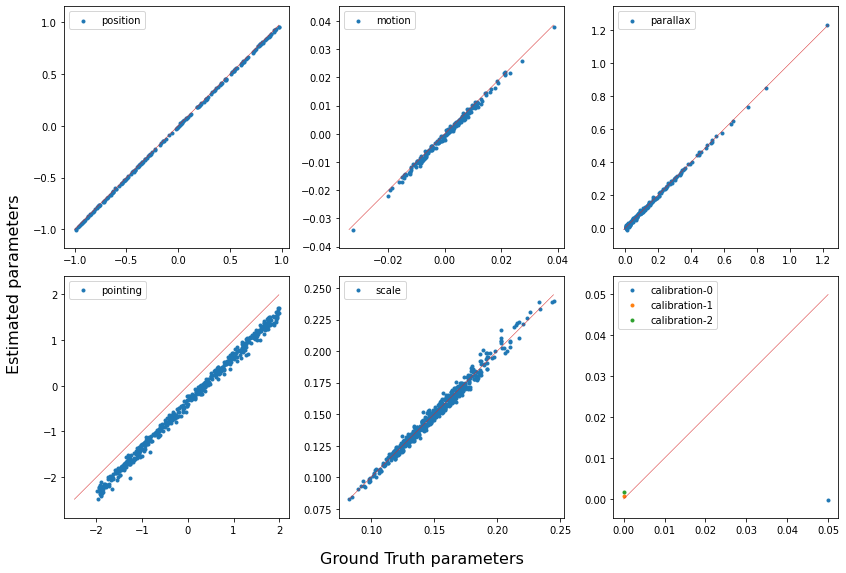

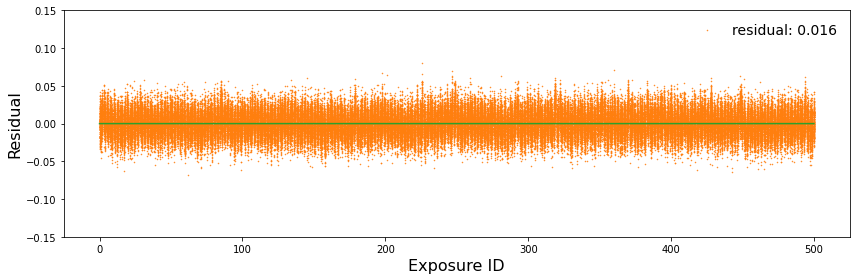

In [17]:
ex = update_exposure(sx, ex, cx)
sx = update_source(sx, ex, cx)
cx = update_calibration(sx, ex, cx)
visualize(sx, ex, cx)

The typical errors are drastically reduced after the iteration. The proper motion is tightly constrained in this setup, possibly due to the relatively long observation duration from $t=-10$ to $10$.

In [18]:
rms = np.std(sx[:, 1:] - src[:, 1:], axis=0)
sigN = sig_obs / np.sqrt(exp.shape[0])

print(f'A typical error in positions     : {rms[0]:.5f} ({rms[0] / sigN:.4f})')
print(f'A typical error in proper motions: {rms[1]:.5f} ({rms[1] / sigN:.4f})')
print(f'A typical error in parallaxes    : {rms[2]:.5f} ({rms[2] / sigN:.4f})')

A typical error in positions     : 0.00435 (6.4875)
A typical error in proper motions: 0.00070 (1.0416)
A typical error in parallaxes    : 0.00643 (9.5876)


The residuals after the second iteration are illustrated below. The RMS residual is 0.015. The parameters seem almost converged. The features that appear in the residual&ndash;exposure ID plot almost dissapear.

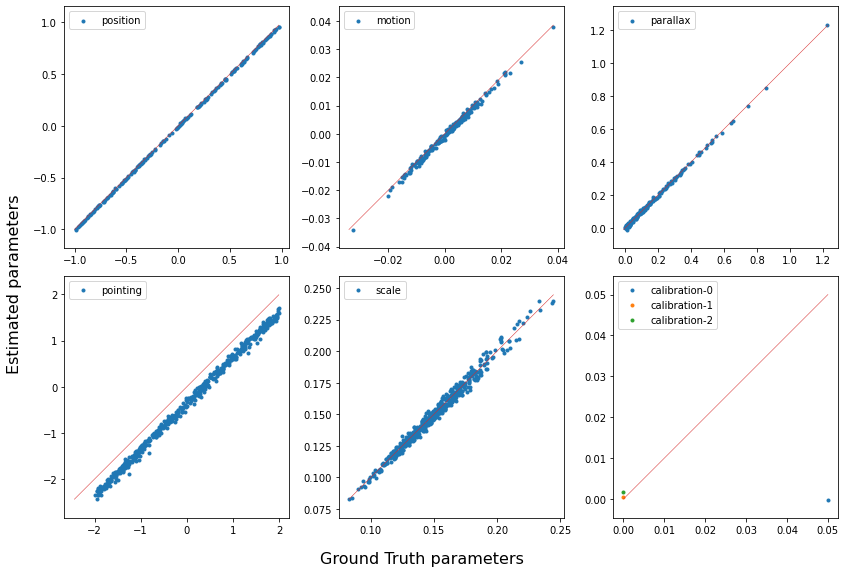

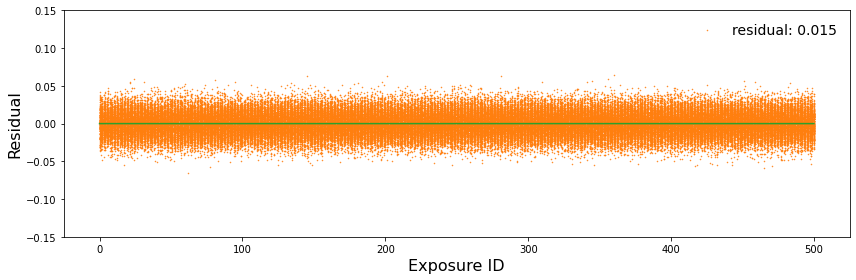

In [19]:
ex = update_exposure(sx, ex, cx)
sx = update_source(sx, ex, cx)
cx = update_calibration(sx, ex, cx)
visualize(sx, ex, cx)

The typical errors are slightly reduced after the second iteration.

In [20]:
rms = np.std(sx[:, 1:] - src[:, 1:], axis=0)
sigN = sig_obs / np.sqrt(exp.shape[0])

print(f'A typical error in positions     : {rms[0]:.5f} ({rms[0] / sigN:.4f})')
print(f'A typical error in proper motions: {rms[1]:.5f} ({rms[1] / sigN:.4f})')
print(f'A typical error in parallaxes    : {rms[2]:.5f} ({rms[2] / sigN:.4f})')

A typical error in positions     : 0.00438 (6.5291)
A typical error in proper motions: 0.00070 (1.0399)
A typical error in parallaxes    : 0.00639 (9.5361)


The parameters after the third iteration is illustrated.

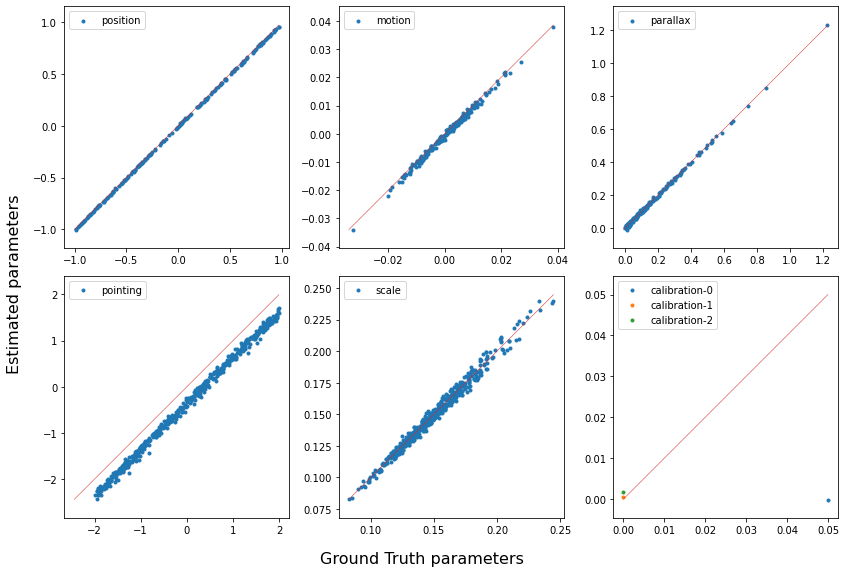

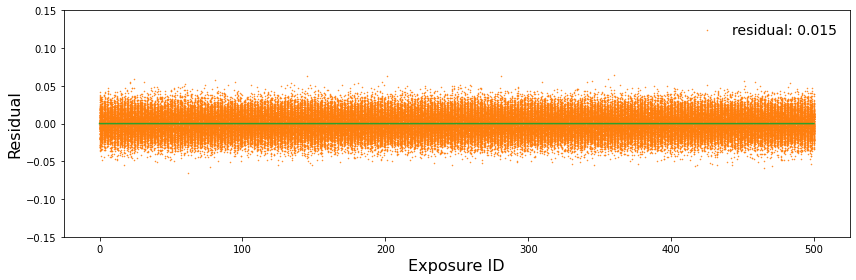

In [21]:
ex = update_exposure(sx, ex, cx)
sx = update_source(sx, ex, cx)
cx = update_calibration(sx, ex, cx)
visualize(sx, ex, cx)

The typical errors after the third iteration are illustrated. The updates from the second iteration are little.

In [22]:
rms = np.std(sx[:, 1:] - src[:, 1:], axis=0)
sigN = sig_obs / np.sqrt(exp.shape[0])

print(f'A typical error in positions     : {rms[0]:.5f} ({rms[0] / sigN:.4f})')
print(f'A typical error in proper motions: {rms[1]:.5f} ({rms[1] / sigN:.4f})')
print(f'A typical error in parallaxes    : {rms[2]:.5f} ({rms[2] / sigN:.4f})')

A typical error in positions     : 0.00438 (6.5284)
A typical error in proper motions: 0.00070 (1.0398)
A typical error in parallaxes    : 0.00636 (9.4879)
